# Implied Volatility Extraction and Visualization

## Extract option data and provide some simple visualization and smoothing to get a general sense of the shape of the volatility surface

### Imports

In [1]:
import calendar
import datetime as dt
import math
import operator as op
import random
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import pytz
import requests
import scipy as sp
import scipy.stats as si

from bs4 import BeautifulSoup
from datetime import date
from collections import Counter
from mpl_toolkits.mplot3d import Axes3D
from plotly.offline import plot
from scipy.interpolate import griddata
from scipy.stats import norm

### Supply a dictionary of option chain urls from Yahoo Finance for S&P 500 options with various maturities

In [3]:
url_dict = {'2020-11-20':str('https://finance.yahoo.com/quote/%5ESPX/options?date=1605830400'),
            '2020-12-18':str('https://finance.yahoo.com/quote/%5ESPX/options?date=1608249600'),
            '2021-01-15':str('https://finance.yahoo.com/quote/%5ESPX/options?date=1610668800'),
            '2021-02-19':str('https://finance.yahoo.com/quote/%5ESPX/options?date=1613692800'),
            '2021-03-19':str('https://finance.yahoo.com/quote/%5ESPX/options?date=1616112000'),
            '2021-06-18':str('https://finance.yahoo.com/quote/%5ESPX/options?date=1623974400'),
            '2021-09-17':str('https://finance.yahoo.com/quote/%5ESPX/options?date=1631836800'),
            '2021-12-17':str('https://finance.yahoo.com/quote/%5ESPX/options?date=1639699200'),
            '2022-06-17':str('https://finance.yahoo.com/quote/%5ESPX/options?date=1655424000'),
            '2022-12-16':str('https://finance.yahoo.com/quote/%5ESPX/options?date=1671148800')}

### Or extract all the urls available for the ticker

In [2]:
def extracturls(ticker):
    """
    Extract the URL for each of the listed option on Yahoo Finance for the given ticker. 

    Parameters
    ----------
    ticker : Str
        Yahoo ticker (Reuters RIC) for the stock.

    Returns
    -------
    Dict
        Dictionary of dates and URLs.

    """

    # Define the stock root webpage
    url = 'https://finance.yahoo.com/quote/'+ticker+'/options?p='+ticker

    # Create a requests object to extract data from the url
    r = requests.get(url)

    # Collect the text fromthis object
    html_doc = r.text

    # Use Beautiful Soup to parse this
    soup = BeautifulSoup(html_doc, features="lxml")

    # Create a list of all the option dates 
    option_dates = [a.get_text() for a in soup.find_all('option')]

    # Convert this list from string to datetimes 
    dates_list = [dt.datetime.strptime(date, "%B %d, %Y").date() for date in option_dates]

    # Convert back to strings in the required format
    str_dates = [date_obj.strftime('%Y-%m-%d') for date_obj in dates_list]

    # Create a list of all the unix dates used in the url for each of these dates
    option_pages = [a.attrs['value'] for a in soup.find_all('option')]

    # Combine the dates and unixdates in a dictionary
    optodict = dict(zip(str_dates, option_pages))

    # Create an empty dictionary
    url_dict = {}

    # For each date and unixdate in the first dictionary
    for date_val, page in optodict.items():

        # Create an entry with the date as key and the url plus unix date as value
        url_dict[date_val] = str('https://finance.yahoo.com/quote/'+ticker+'/options?date='+page)

    return url_dict    

In [3]:
url_dict = extracturls('^SPX')

### Extract the option data from these urls

In [6]:
def extractoptions(url_dict, wait=1):
    """
    Extract option data from Yahoo Finance

    Parameters
    ----------
    url_dict : Dict
        Dictionary of URLs to download option prices from.
    wait : Int
        Number of seconds to wait between each url query

    Returns
    -------
    DataFrame
        All option data from each of the supplied urls.

    """    
   
    # Create an empty dictionary
    df_dict = {}
    url_except_dict = {}

    # each url needs to have an option expiry date associated with it in the url dict 
    for input_date, url in url_dict.items():

        # requests function downloads the data            
        html = requests.get(url).content

        # wait between each query so as not to overload server
        time.sleep(wait)

        # if data exists
        try:
            # read html data into a DataFrame 
            df = pd.read_html(html)

            # Add this DataFrame to the default dictionary, named with the expiry date it refers to
            df_dict[input_date] = df

        # otherwise collect dictionary of exceptions
        except:
            url_except_dict[input_date] = url

    # Create an empty DataFrame
    full_data = pd.DataFrame()

    # Make a list of all the dates of the DataFrames just stored in the default dictionary
    date_list = list(df_dict.keys()) 

    # Create list to store exceptions
    opt_except_list = []

    # For each of these dates
    for input_date in date_list:

        try:
            # The first entry is 'calls'
            calls = df_dict[input_date][0]

            # Create a column designating these as calls
            calls['Option Type'] = 'call'

            try:
                # The second entry is 'puts'
                puts = df_dict[input_date][1]

                # Create a column designating these as puts
                puts['Option Type'] = 'put'

                # Concatenate these two DataFrames
                options = pd.concat([calls, puts])

                # Add an 'Expiry' column with the expiry date
                options['Expiry'] = pd.to_datetime(input_date).date()

                # Add this DataFrame to 'full_data'
                full_data = pd.concat([full_data, options])

            except:

                # Add an 'Expiry' column with the expiry date
                calls['Expiry'] = pd.to_datetime(input_date).date()

                # Add this DataFrame to 'full_data'
                full_data = pd.concat([full_data, calls])

        except:

            try:
                # The second entry is 'puts'
                puts = df_dict[input_date][1]

                # Create a column designating these as puts
                puts['Option Type'] = 'put'

                # Add an 'Expiry' column with the expiry date
                puts['Expiry'] = pd.to_datetime(input_date).date()

                # Add this DataFrame to 'full_data'
                full_data = pd.concat([full_data, puts])

            except:
                opt_except_list.append(input_date)


    return full_data, url_except_dict, opt_except_list


In [7]:
full_data, except_dict, opt_except_list = extractoptions(url_dict, wait=1)

### Filter the data for only recent quotes and format dates, add Mid Price, Time To Maturity columns and restrict to options expiring on the 3rd Friday 

In [8]:
def transform(start_date, url_dict, full_data, lastmins=None, mindays=None, minopts=None, volume=None, 
                  openint=None, monthlies=False):    
    """
    Perform some filtering / transforming of the option data

    Parameters
    ----------
    start_date : Str
        Date from when to include prices (some of the options won't have traded 
                                          for days / weeks and therefore will have stale prices).
    lastmins : Int, Optional 
        Restrict to trades within number of minutes since last trade time recorded
    mindays : Int, Optional    
        Restrict to options greater than certain option expiry
    minopts : Int, Optional
        Restrict to minimum number of options to include that option expiry
    volume : Int, Optional    
        Restrict to minimum Volume
    openint : Int, Optional
        Restrict to minimum Open Interest
    monthlies : Bool    
        Restrict expiries to only 3rd Friday of the month. Default is False.

    Returns
    -------
    DataFrame
        Creates a new DataFrame as a modification of 'full_data'.

    """

    # Make a copy of 'full_data'
    data = full_data.copy()

    # Set timezone
    est = pytz.timezone('US/Eastern')

    # Convert 'Last Trade Date' to a DateTime variable
    data['Last Trade Date Raw'] = data['Last Trade Date']
    data['Last Trade Date'] = pd.to_datetime(data['Last Trade Date'], format='%Y-%m-%d %I:%M%p EDT')
    data['Last Trade Date'] = data['Last Trade Date'].apply(lambda x: x.replace(tzinfo=est))

    # Create columns of expiry date as datetime object and str
    data['Expiry_datetime'] = pd.to_datetime(data['Expiry'], format='%Y-%m-%d')
    data['Expiry_str'] = data['Expiry_datetime'].dt.strftime('%Y-%m-%d')

    # Filter data from start date
    data = data[data['Last Trade Date']  >= str(pd.to_datetime(start_date))]

    # Create a column of the Trade Day
    data['Last Trade Day'] = data['Last Trade Date'].dt.date

    # Create a column of the Trade Time of Day
    data['Last Trade Time'] = data['Last Trade Date'].dt.time

    # Create a column of the Trade Hour of Day
    data['Last Trade Hour'] = data['Last Trade Date'].dt.hour

    # Create a column of the Trade Date represented in unixtime
    data['Unixtime'] = data['Last Trade Date'].astype(np.int64) // 10**9

    # Clean Volume column
    data['Volume'] = data['Volume'].replace('-',0).astype(int)

    # Clean Open Interest column
    data['Open Interest'] = data['Open Interest'].replace('-',0).astype(int)

    # Clean Bid column 
    data['Bid'] = data['Bid'].replace('-',0).astype(float)

    # Create Mid column
    data['Mid'] = (data['Ask'] + data['Bid']) / 2

    # Create Time To Maturity (in years) column
    data['TTM'] = (pd.to_datetime(data['Expiry']) - pd.to_datetime(date.today())) / (pd.Timedelta(days=1) * 365)

    # Create Days to Maturity column
    data['Days'] = (data['TTM']*365).astype(int)

    # If a minutes parameter is supplied, filter for most recent minutes
    if lastmins is not None:
        data = data[data['Unixtime']  >= (max(data['Unixtime']) - lastmins * 60)]

    # If a mindays parameter is supplied, filter for option expiry greater than parameter 
    if mindays is not None:
        data = data[data['Days']  >= mindays]

    # If a minopts parameter is supplied, filter for volume greater than parameter 
    if minopts is not None:

        # Create a dictionary of the number of options for each maturity
        mat_dict = dict(Counter(data['Days']))
        for ttm, count in mat_dict.items():

            # if there are less than minopts options for a given maturity
            if count < minopts:

                # remove that maturity from the DataFrame
                data = data[data['Days'] != ttm]  

    # If a volume parameter is supplied, filter for volume greater than parameter 
    if volume is not None:
        data = data[data['Volume']  >= volume]

    # If an openint parameter is supplied, filter for Open Interest greater than parameter   
    if openint is not None:
        data = data[data['Open Interest']  >= openint]                          

    # If the monthlies flag is set
    if monthlies == True:

        # Create an empty list
        date_list = []

        # For each date in the url_dict 
        for key in url_dict.keys():

            # Format that string as a datetime object
            key_date = dt.datetime.strptime(key, "%Y-%m-%d")

            # Store the year and month as a tuple in date_list
            date_list.append((key_date.year, key_date.month))

        # Create a sorted list from the unique dates in date_list
        sorted_dates = sorted(list(set(date_list)))

        # Create an empty list
        days_list = []

        # Create a calendar object
        c = calendar.Calendar(firstweekday=calendar.SATURDAY)

        # For each tuple of year, month in sorted_dates
        for tup in sorted_dates:

            # Create a list of lists of days in that month
            monthcal = c.monthdatescalendar(tup[0], tup[1])

            # Extract the date corresponding to the 3rd Friday 
            expiry = monthcal[2][-1]

            # Calculate the number of days until that expiry
            ttm = (expiry - dt.date.today()).days

            # Append this to the days_list
            days_list.append(ttm)

        # For each unique number of days to expiry
        for days_to_expiry in set(data['Days']):

            # if the expiry is not in the list of monthly expiries
            if days_to_expiry not in days_list:

                # Remove that expiry from the DataFrame
                data = data[data['Days'] != days_to_expiry] 

    return data

In [9]:
start_date = '2020-10-21'
data = transform(start_date, url_dict, full_data, monthlies=True)

### Lookup dictionaries

In [10]:
row_dict={'Bid':'Imp Vol - Bid',
          'Mid':'Imp Vol - Mid',
          'Ask':'Imp Vol - Ask',
          'Last Price':'Imp Vol - Last'}

prices_dict={'bid':'Bid',
             'mid':'Mid',
             'ask':'Ask',
             'last':'Last Price'}

vols_dict={'bid':'Imp Vol - Bid',
           'mid':'Imp Vol - Mid',
           'ask':'Imp Vol - Ask',
           'last':'Imp Vol - Last'}

### Methods used to calculate implied volatility

In [11]:
def bsm(S, K, T, r, q, sigma, option='call'):
    """
    Black-Scholes-Merton Option price 

    Parameters
    ----------
    S : Float
        Stock Price.
    K : Float
        Strike Price.
    T : Float
        Time to Maturity.
    r : Float
        Interest Rate.
    q : Float
        Dividend Yield.
    sigma : Float
        Implied Volatility.
    option : Str
        Type of option. 'put' or 'call'.

    Returns
    -------
    opt_price : Float
        Option Price.

    """
    b = r - q
    carry = np.exp((b - r) * T)
    d1 = (np.log(S / K) + (b + (0.5 * sigma ** 2)) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S / K) + (b - (0.5 * sigma ** 2)) * T) / (sigma * np.sqrt(T))

    # Cumulative normal distribution function
    Nd1 = si.norm.cdf(d1, 0.0, 1.0)
    minusNd1 = si.norm.cdf(-d1, 0.0, 1.0)
    Nd2 = si.norm.cdf(d2, 0.0, 1.0)
    minusNd2 = si.norm.cdf(-d2, 0.0, 1.0)

    if option == "call":
        opt_price = ((S * carry * Nd1) - 
                          (K * np.exp(-r * T) * Nd2))  
    if option == 'put':
        opt_price = ((K * np.exp(-r * T) * minusNd2) - 
                          (S * carry * minusNd1))

    return opt_price


def bsm_vega(S, K, T, r, q, sigma, option='call'):
    """
    Black-Scholes-Merton Option Vega 

    Parameters
    ----------
    S : Float
        Stock Price.
    K : Float
        Strike Price.
    T : Float
        Time to Maturity.
    r : Float
        Interest Rate.
    q : Float
        Dividend Yield.
    sigma : Float
        Implied Volatility.
    option : Str
        Type of option. 'put' or 'call'.

    Returns
    -------
    opt_vega : Float
        Option Vega.

    """    
    b = r - q
    carry = np.exp((b - r) * T)
    d1 = (np.log(S / K) + (b + (0.5 * sigma ** 2)) * T) / (sigma * np.sqrt(T))
    nd1 = (1 / np.sqrt(2 * np.pi)) * (np.exp(-d1 ** 2 * 0.5))

    opt_vega = S * carry * nd1 * np.sqrt(T)

    return opt_vega




def newtonraphson(S, K, T, r, q, cm, epsilon, option):
    """
    Finds implied volatility using Newton-Raphson method - needs knowledge of 
    partial derivative of option pricing formula with respect to volatility (vega)

    Parameters
    ----------
    S : Float
        Stock Price.
    K : Float
        Strike Price.
    T : Float
        Time to Maturity.
    r : Float
        Interest Rate.
    q : Float
        Dividend Yield.
    cm : Float
        Option Price.
    epsilon : Float
        Degree of precision.
    option : Str
        Type of option. 'put' or 'call'.

    Returns
    -------
    result : Float
        Implied Volatility.

    """

    # Manaster and Koehler seed value
    vi = np.sqrt(abs(np.log(S / K) + r * T) * 2 / T)
    ci = bsm(S, K, T, r, q, vi, option)    
    vegai = bsm_vega(S, K, T, r, q, vi)
    minDiff = abs(cm - ci)

    while abs(cm - ci) >= epsilon and abs(cm - ci) <= minDiff:
        vi = vi - (ci - cm) / vegai
        ci = bsm(S, K, T, r, q, vi, option)
        vegai = bsm_vega(S, K, T, r, q, vi)
        minDiff = abs(cm - ci)

    if abs(cm - ci) < epsilon:
        result = vi
    else:
        result = 'NA'

    return result


def imp_vol_by_row(row, S, K, r, q, epsilon, option):
    """
    Private function used to calculate implied vol for one row of a DataFrame.

    Parameters
    ----------
    row : Array
        Each row in the DataFrame.
    S : Float
        Stock Price.
    K : Float
        Strike Price.
    r : Float
        Interest Rate.
    q : Float
        Dividend Yield.
    epsilon : Float
        Degree of precision to return implied vol. 
    option : Str
        Option type; 'put' or 'call'.
    method : Str
        Implied Vol method; 'newtonraphson', 'bisection' or 'iv_naive'.

    Returns
    -------
    row : Array
        Each row in the DataFrame.

    """

    # for each of the prices: bid, mid, ask, last
    for input_row, output_row in row_dict.items():

        # populate the column using the chosen implied vol method 
        # (using getattr() to select dynamically)
        row[output_row] = newtonraphson(S=S, K=K, T=row['TTM'], r=r, q=q, 
                                        cm=row[input_row], epsilon=epsilon, option=option)

    return row


def imp_vol_apply(input_data, S, K, r, q, epsilon, option):
    """
    Private function used to apply _implied_vol_by_row method to each row of a DataFrame.

    Parameters
    ----------
    input_data : DataFrame
        DataFrame of Option prices.
    S : Float
        Stock Price.
    K : Float
        Strike Price.
    r : Float
        Interest Rate. The default is 0.005.
    q : Float
        Dividend Yield. The default is 0.
    epsilon : Float
        Degree of precision to return implied vol. The default is 0.001.
    option : Str
        Option type; 'put' or 'call'.
    method : Str
        Implied Vol method; 'newtonraphson', 'bisection' or 'iv_naive'. The default is 'NR'.

    Returns
    -------
    input_data : DataFrame
        DataFrame of Option prices.

    """

    # Filter data by strike and option type
    input_data = input_data[(input_data['Strike'] == K) & (input_data['Option Type'] == option)]

    # Apply implied vol method to each row
    input_data = input_data.apply(lambda x: imp_vol_by_row(x, S, K, r, q, epsilon, option), axis=1)

    return input_data         


def combine(data, ticker_label, put_strikes, call_strikes, spot, 
            r=None, q=None, epsilon=None, method=None):
    """
    Calculate implied volatilities for specified put and call strikes and combine.

    Parameters
    ----------
    ticker_label : Str
        Stcok Ticker.
    put_strikes : List
        Range of put strikes to calculate implied volatility for.
    call_strikes : List
        Range of call strikes to calculate implied volatility for.
    spot : Float
        Underlying reference level.
    r : Float
        Interest Rate. The default is 0.005.
    q : Float
        Dividend Yield. The default is 0.
    epsilon : Float
        Degree of precision to return implied vol. The default is 0.001.
    method : Str
        Implied Vol method; 'newtonraphson', 'bisection' or 'iv_naive'. The default is 'NR'.

    Returns
    -------
    DataFrame
        DataFrame of Option prices.

    """

    # create copy of filtered data
    input_data = data.copy()

    # Create empty list and dictionary for storing options
    opt_list = []
    opt_dict = {}

    # For each put strike price
    for strike in put_strikes:

        # Assign an option name of ticker plus strike 
        opt_name = ticker_label+'_'+str(strike)

        # store the implied vol results for that strike in the option dictionary 
        opt_dict[opt_name] = imp_vol_apply(input_data=input_data, S=spot, K=strike, 
                                                      r=r, q=q, epsilon=epsilon, option='put')

        # store the implied vol results for that strike in the option list
        opt_list.append(opt_dict[opt_name])

    # For each put strike price    
    for strike in call_strikes:

        # Assign an option name of ticker plus strike 
        opt_name = ticker_label+'_'+str(strike)

        # store the implied vol results DataFrame for that strike in the option dictionary 
        opt_dict[opt_name] = imp_vol_apply(input_data=input_data, S=spot, K=strike, 
                                           r=r, q=q, epsilon=epsilon, option='call')

        # store the implied vol results DataFrame for that strike in the option list
        opt_list.append(opt_dict[opt_name])    

    # Concatenate all the option results into a single DataFrame
    imp_vol_data = pd.concat(opt_list)

    return imp_vol_data

### Select a range of call and put strikes and spot reference and create data

In [12]:
put_strikes = list(range(2600, 3400, 25))
call_strikes = list(range(3400, 4250, 25))
ticker_label = 'SPX'
spot = 3434.46

In [13]:
imp_vol_data = combine(data, ticker_label, put_strikes, call_strikes, spot, r=0.005, q=0, epsilon=0.001)

## Visualization functions

### Function to select graph to display

In [14]:
def visualize(imp_vol_data, graphtype='line', surfacetype='mesh', smoothing=False, scatter=False, 
                  voltype='last', order=3, spacegrain=100, rbffunc='thin_plate', colorscale='BlueRed', 
                  notebook=True):
    """
    Visualize the implied volatility as 2D linegraph, 3D scatter or 3D surface

    Parameters
    ----------
    graphtype : Str
        Whether to display 'line', 'scatter' or 'surface'. The default is 'line'.
    surfacetype : Str
        The type of 3D surface to display from 'trisurf', 'mesh', spline', 
        'interactive_mesh' and 'interactive_spline'. The default is 'mesh'.
    smoothing : Bool
        Whether to apply polynomial smoothing. The default is False.
    scatter : Bool
        Whether to plot scatter points on 3D mesh grid. The default is False.
    voltype : Str
        Whether to use 'bid', 'mid', 'ask' or 'last' price. The default is 'last'.
    order : Int
        Polynomial order used in numpy polyfit function. The default is 3.
    spacegrain : Int
        Number of points in each axis linspace argument for 3D graphs. The default is 100.
    rbffunc : Str
        Radial basis function used in interpolation chosen from 'multiquadric', 
        'inverse', 'gaussian', 'linear', 'cubic', 'quintic', 'thin_plate'. The 
        default is 'thin_plate'     
    colorscale : Str
        Colors used in plotly interactive graph. The default is 'BlueRed'
    notebook : Bool
        Whether interactive graph is run in Jupyter notebook or IDE. The default is False.

    Returns
    -------
    Displays the output of the chosen graphing method.

    """

    # Run method selected by graphtype
    if graphtype == 'line':
        line_graph(imp_vol_data, voltype=voltype)
    if graphtype == 'scatter':
        scatter_3D(imp_vol_data, voltype=voltype)
    if graphtype == 'surface':
        surface_3D(imp_vol_data, surfacetype=surfacetype, smoothing=smoothing, scatter=scatter, 
                        voltype=voltype, order=order, spacegrain=spacegrain, 
                        rbffunc=rbffunc, colorscale=colorscale, notebook=notebook)




### Function to create Line Graph

In [15]:
def line_graph(imp_vol_data, voltype='last'):
    """
    Displays a linegraph of each option maturity plotted by strike and implied vol

    Parameters
    ----------
    voltype : Str
        Whether to use 'bid', 'mid', 'ask' or 'last' price. The default is 'last'.

    Returns
    -------
    Linegraph.

    """

    # Create a sorted list of the different number of option expiries
    dates = sorted(list(set(imp_vol_data['Expiry'])))

    # Create a sorted list of the different number of option time to maturity
    tenors = sorted(list(set(imp_vol_data['TTM'])))

    # Combine these in a dictionary
    tenor_date_dict = dict(zip(dates, tenors))

    # Create figure, axis objects        
    fig, ax = plt.subplots(figsize=(14,12))
    plt.style.use('seaborn-darkgrid')

    # Set fontsize of axis ticks
    ax.tick_params(axis='both', which='major', labelsize=14)

    # For each expiry date
    for exp_date, tenor in tenor_date_dict.items():

        # Plot the specified voltype against strike
        ax.plot(imp_vol_data[imp_vol_data['TTM']==tenor]['Strike'], 
                imp_vol_data[imp_vol_data['TTM']==tenor][str(vols_dict[str(voltype)])] * 100, 
                label=str(exp_date)+' Expiry')
    plt.grid(True)

    # Label axes 
    ax.set_xlabel('Strike', fontsize=14)
    ax.set_ylabel('Implied Volatility %', fontsize=14)

    # Set legend title and font sizes
    ax.legend(title="Option Expiry", fontsize=12, title_fontsize=15)

    # Specify title with ticker label, voltype and date and shift away from chart
    st = fig.suptitle(str(ticker_label.upper())+' Implied Volatility '+str(voltype.title())+
                 ' Price '+str(start_date), fontsize=18, fontweight=0, color='black', style='italic', y=1.02)
    st.set_y(0.95)
    fig.subplots_adjust(top=0.9)

    # Display graph
    plt.show()


### Function to create 3D Scatter Plot

In [16]:
def scatter_3D(imp_vol_data, voltype='last'):
    """
    Displays a 3D scatter plot of each option implied vol against strike and maturity

    Parameters
    ----------
    voltype : Str
        Whether to use 'bid', 'mid', 'ask' or 'last' price. The default is 'last'.

    Returns
    -------
    3D Scatter plot.

    """


    # Create figure and axis objects
    fig = plt.figure(figsize=(15, 12))
    ax = fig.add_subplot(111, projection='3d')

    # Set fontsize of axis ticks
    ax.tick_params(axis='both', which='major', labelsize=14)

    # Create copy of data
    data_3D = imp_vol_data.copy()

    # Filter out any zero prices
    data_3D = data_3D[data_3D[str(prices_dict[str(voltype)])] != 0]

    # Specify the 3 axis values
    x = data_3D['Strike']
    y = data_3D['TTM'] * 365
    z = data_3D[str(vols_dict[str(voltype)])] * 100

    # Label axes
    ax.set_xlabel('Strike', fontsize=14, labelpad=15)
    ax.set_ylabel('Time to Expiration (Days)', fontsize=14, labelpad=15)
    ax.set_zlabel('Implied Volatility %', fontsize=14, labelpad=15)

    # Specify title with ticker label, voltype and date
    ax.set_title(str(ticker_label.upper())+' Implied Volatility '+str(voltype.title())+
                 ' Price '+str(start_date), fontsize=18)       

    # Display scatter, specifying colour to vary with z-axis and use colormap 'viridis'
    ax.scatter3D(x, y, z, c=z, cmap='viridis')

### Function to create 3D Surface Plot

In [17]:
def surface_3D(imp_vol_data, surfacetype='mesh', smoothing=False, scatter=False, voltype='last', 
                   order=3, spacegrain=100, rbffunc='thin_plate', colorscale='BlueRed', notebook=True):
    """
    Displays a 3D surface plot of the implied vol surface against strike and maturity

    Parameters
    ----------
    surfacetype : Str
        The type of 3D surface to display from 'trisurf', 'mesh', spline', 
        'interactive_mesh' and 'interactive_spline'. The default is 'mesh'.
    smoothing : Bool
        Whether to apply polynomial smoothing. The default is False.
    scatter : Bool
        Whether to plot scatter points on 3D mesh grid. The default is False.
    voltype : Str
        Whether to use 'bid', 'mid', 'ask' or 'last' price. The default is 'last'.
    order : Int
        Polynomial order used in numpy polyfit function. The default is 3.
    spacegrain : Int
        Number of points in each axis linspace argument for 3D graphs. The default 
        is 100.
    rbffunc : Str
        Radial basis function used in interpolation chosen from 'multiquadric', 
        'inverse', 'gaussian', 'linear', 'cubic', 'quintic', 'thin_plate'. The 
        default is 'thin_plate'
    colorscale : Str
        Colors used in plotly interactive graph. The default is 'BlueRed'
    notebook : Bool
        Whether interactive graph is run in Jupyter notebook or IDE. The default 
        is False.

    Returns
    -------
    3D surface plot.

    """


    # If smoothing is set to False
    if smoothing == False:

        # Create copy of implied vol data
        data_3D = imp_vol_data.copy()

        # Filter out any zero prices
        data_3D = data_3D[data_3D[str(prices_dict[str(voltype)])] != 0]

        # Set 'graph vol' to be the specified voltype
        data_3D['Graph Vol'] = data_3D[str(vols_dict[str(voltype)])]

    # Otherwise, if smoothing is set to True
    else:

        # Apply the smoothing function to the specified voltype
        imp_vol_data_smoothed = smooth(imp_vol_data, order=order, voltype=voltype)

        # Create copy of implied vol data
        data_3D = imp_vol_data_smoothed.copy()

        # Filter out any zero prices
        data_3D = data_3D[data_3D[str(prices_dict[str(voltype)])] != 0]

        # Set 'graph vol' to be the smoothed vol
        data_3D['Graph Vol'] = data_3D['Smoothed Vol']

    # Specify the 3 axis values
    x = data_3D['Strike']
    y = data_3D['TTM'] * 365
    z = data_3D['Graph Vol'] * 100


    if surfacetype == 'trisurf':

        # Create figure and axis objects
        fig = plt.figure(figsize=(15, 12))
        ax = fig.add_subplot(111, projection='3d')

        # Set fontsize of axis ticks
        ax.tick_params(axis='both', which='major', labelsize=14)

        # Label axes
        ax.set_xlabel('Strike', fontsize=14, labelpad=15)
        ax.set_ylabel('Time to Expiration (Days)', fontsize=14, labelpad=15)
        ax.set_zlabel('Implied Volatility %', fontsize=14, labelpad=15)

        # Specify title with ticker label, voltype and date
        ax.set_title(str(ticker_label.upper())+' Implied Volatility '+str(voltype.title())+
                 ' Price '+str(start_date), fontsize=18) 

        # Display triangular surface plot, using colormap 'viridis'
        ax.plot_trisurf(x, y, z, cmap='viridis', edgecolor='none')


    if surfacetype == 'mesh':

        # Create arrays across x and y-axes of equally spaced points from min to max values
        x1, y1 = np.meshgrid(np.linspace(min(x), max(x), int(spacegrain)), 
                            np.linspace(min(y), max(y), int(spacegrain)))

        # Map the z-axis with the scipy griddata method, applying cubic spline interpolation
        z1 = griddata(np.array([x,y]).T, np.array(z), (x1,y1), method='cubic')

        # Create figure and axis objects
        fig = plt.figure(figsize=(12, 9))
        ax = Axes3D(fig, azim=-60, elev=30)

        # Set fontsize of axis ticks
        ax.tick_params(axis='both', which='major', labelsize=14)

        # Plot the surface
        ax.plot_surface(x1, y1, z1)

        # Apply contour lines
        ax.contour(x1, y1, z1)

        # Label axes
        ax.set_xlabel('Strike', fontsize=14, labelpad=15)
        ax.set_ylabel('Time to Expiration (Days)', fontsize=14, labelpad=15)
        ax.set_zlabel('Implied Volatility %', fontsize=14, labelpad=15)

        # Specify title with ticker label, voltype and date
        ax.set_title(str(ticker_label.upper())+' Implied Volatility '+str(voltype.title())+
                 ' Price '+str(start_date), fontsize=18) 
        plt.show()


    if surfacetype == 'spline':

        # Create arrays across x and y-axes of equally spaced points from min to max values
        x1 = np.linspace(min(x), max(x), int(spacegrain))
        y1 = np.linspace(min(y), max(y), int(spacegrain))
        x2, y2 = np.meshgrid(x1, y1, indexing='xy')

        # Initialize the z-axis as an array of zero values
        z2 = np.zeros((x.size, z.size))

        # Apply scipy interpolate radial basis function, choosing the rbffunc parameter 
        spline = sp.interpolate.Rbf(x, y, z, function=rbffunc, smooth=5, episilon=5)

        # Populate z-axis array using this function
        z2 = spline(x2, y2)

        # Create figure and axis objects
        fig = plt.figure(figsize=(12,9))
        ax = Axes3D(fig)

        # Set fontsize of axis ticks
        ax.tick_params(axis='both', which='major', labelsize=14)

        # Label axes
        ax.set_xlabel('Strike', fontsize=14, labelpad=15)
        ax.set_ylabel('Time to Expiration (Days)', fontsize=14, labelpad=15)
        ax.set_zlabel('Implied Volatility %', fontsize=14, labelpad=15)

        # Specify title with ticker label, voltype and date
        ax.set_title(str(ticker_label.upper())+' Implied Volatility '+str(voltype.title())+
                 ' Price '+str(start_date), fontsize=18) 

        # Plot the surface
        ax.plot_wireframe(x2, y2, z2)
        ax.plot_surface(x2, y2, z2, alpha=0.2)

        # If scatter is True, overlay the surface with the unsmoothed scatter points
        if scatter == True:
            z = data_3D[str(vols_dict[str(voltype)])] * 100
            ax.scatter3D(x, y, z, c='r')


    if surfacetype in ['interactive_mesh', 'interactive_spline']:

        # Set the range of x, y and z contours and interval
        contour_x_start = 0
        contour_x_stop = 2 * 360
        contour_x_size = contour_x_stop / 18
        contour_y_start = data_3D['Strike'].min()
        contour_y_stop = data_3D['Strike'].max()

        # Vary the strike interval based on spot level
        if (data_3D['Strike'].max() - data_3D['Strike'].min()) > 2000:
            contour_y_size = 200
        elif (data_3D['Strike'].max() - data_3D['Strike'].min()) > 1000:
            contour_y_size = 100
        elif (data_3D['Strike'].max() - data_3D['Strike'].min()) > 250:
            contour_y_size = 50
        else:
            contour_y_size = 25
        contour_z_start = 0
        contour_z_stop = 0.5
        contour_z_size = 0.05

        # Specify the 3 axis values            
        x = data_3D['TTM'] * 365
        y = data_3D['Strike']
        z = data_3D['Graph Vol'] * 100

        # Create arrays across x and y-axes of equally spaced points from min to max values
        x1 = np.linspace(x.min(), x.max(), int(spacegrain))
        y1 = np.linspace(y.min(), y.max(), int(spacegrain))
        x2, y2 = np.meshgrid(x1, y1, indexing='xy')

        # If surfacetype is 'interactive_mesh', map the z-axis with the scipy 
        # griddata method, applying cubic spline interpolation
        if surfacetype == 'interactive_mesh':
            z2 = griddata((x, y), z, (x2, y2), method='cubic')

        # If surfacetype is 'interactive_spline', apply scipy interpolate radial 
        # basis function, choosing the rbffunc parameter
        if surfacetype == 'interactive_spline':
            z2 = np.zeros((x.size, z.size))
            spline = sp.interpolate.Rbf(x, y, z, function=rbffunc, smooth=5, episilon=5)
            z2 = spline(x2, y2)

        # Initialize Figure object
        fig = go.Figure(data=[go.Surface(x=x2, 
                                         y=y2, 
                                         z=z2,

                                         # Specify the colors to be used
                                         colorscale=colorscale,

                                         # Define the contours
                                         contours = {"x": {"show": True, "start": contour_x_start, 
                                                           "end": contour_x_stop, "size": contour_x_size, "color":"white"},            
                                                     "y": {"show": True, "start": contour_y_start, 
                                                           "end": contour_y_stop, "size": contour_y_size, "color":"white"},  
                                                     "z": {"show": True, "start": contour_z_start, 
                                                           "end": contour_z_stop, "size": contour_z_size}},)])

        # Set initial camera angle
        camera = dict(
            eye=dict(x=2, y=1, z=1)
        )

        # Set Time To Expiration to increase left to right
        fig.update_scenes(xaxis_autorange="reversed")
        fig.update_layout(scene = dict(
                            xaxis = dict(
                                 backgroundcolor="rgb(200, 200, 230)",
                                 gridcolor="white",
                                 showbackground=True,
                                 zerolinecolor="white",),
                            yaxis = dict(
                                backgroundcolor="rgb(230, 200,230)",
                                gridcolor="white",
                                showbackground=True,
                                zerolinecolor="white"),
                            zaxis = dict(
                                backgroundcolor="rgb(230, 230,200)",
                                gridcolor="white",
                                showbackground=True,
                                zerolinecolor="white",),
                            # Label axes
                            xaxis_title='Time to Expiration (Days)',
                            yaxis_title='Underlying Value',
                            zaxis_title='Implied Volatility %',),
                          # Specify title with ticker label, voltype and date
                          title={'text':(str(ticker_label.upper())+' Implied Volatility '+str(voltype.title())+
                                 ' Price '+str(start_date)),
                                 'y':0.9,
                                 'x':0.5,
                                 'xanchor':'center',
                                 'yanchor':'top',
                                 'font':dict(#family="Courier New, monospace",
                                           size=20,
                                           color="black")},
                          autosize=False, 
                          width=800, height=800,
                          margin=dict(l=65, r=50, b=65, t=90),
                          scene_camera=camera)

        # If running within a Jupyter notebook, plot graph inline
        if notebook == True:
            fig.show()

        # Otherwise create a new HTML window to display    
        else:
            plot(fig, auto_open=True)

### Methods for smoothing data

In [18]:
def vol_map(row, smooth_surf):
    """
    Map value calculated in smooth surface DataFrame to 'Smoothed Vol' column.

    Parameters
    ----------
    row : Array
        Each row in the DataFrame.

    Returns
    -------
    row : Array
        Each row in the DataFrame.

    """
    row['Smoothed Vol'] = smooth_surf.loc[row['Strike'], str(row['Days'])]

    return row


def smooth(imp_vol_data, order=3, voltype='last', smoothopt=6):
    """
    Create a column of smoothed implied vols

    Parameters
    ----------
    order : Int
        Polynomial order used in numpy polyfit function. The default is 3.
    voltype : Str
        Whether to use 'bid', 'mid', 'ask' or 'last' price. The default is 'last'.
    smoothopt : Int    
        Minimum number of options to fit curve to

    Returns
    -------
    DataFrame
        DataFrame of Option prices.

    """

    # Create a dictionary of the number of options for each maturity
    mat_dict = dict(Counter(imp_vol_data['Days']))

    # Create a sorted list of the different number of days to maturity
    maturities = sorted(list(set(imp_vol_data['Days'])))

    # Create a sorted list of the different number of strikes
    strikes_full = sorted(list(set((imp_vol_data['Strike'].astype(int)))))

    # create copy of implied vol data
    imp_vol_data_smoothed = imp_vol_data.copy()

    for ttm, count in mat_dict.items():

        # if there are less than smoothopt (default is 6) options for a given maturity
        if count < smoothopt:

            # remove that maturity from the maturities list
            maturities.remove(ttm)

            # and remove that maturity from the implied vol DataFrame
            imp_vol_data_smoothed = imp_vol_data_smoothed[imp_vol_data_smoothed['Days'] != ttm]            

    # Create empty DataFrame with the full range of strikes as index
    smooth_surf = pd.DataFrame(index=strikes_full)

    # going through the maturity list (in reverse so the columns created are in increasing order)
    for maturity in reversed(maturities):

        # Extract the strikes for this maturity
        strikes = imp_vol_data[imp_vol_data['Days']==maturity]['Strike']

        # And the vols (specifying the voltype)
        vols = imp_vol_data[imp_vol_data['Days']==maturity][str(vols_dict[str(voltype)])]

        # Fit a polynomial to this data
        curve_fit = np.polyfit(strikes, vols, order)
        p = np.poly1d(curve_fit)

        # Create empty list to store smoothed implied vols
        iv_new = []

        # For each strike
        for strike in strikes_full:

            # Add the smoothed value to the iv_new list 
            iv_new.append(p(strike))

        # Append this list as a new column in the smooth_surf DataFrame    
        smooth_surf.insert(0, str(maturity), iv_new) 

    # Apply the _vol_map function to add smoothed vol column to DataFrame
    imp_vol_data_smoothed = imp_vol_data_smoothed.apply(lambda x: vol_map(x, smooth_surf), axis=1)

    return imp_vol_data_smoothed


### Display a line graph of the implied volatilities of the various maturities by strike

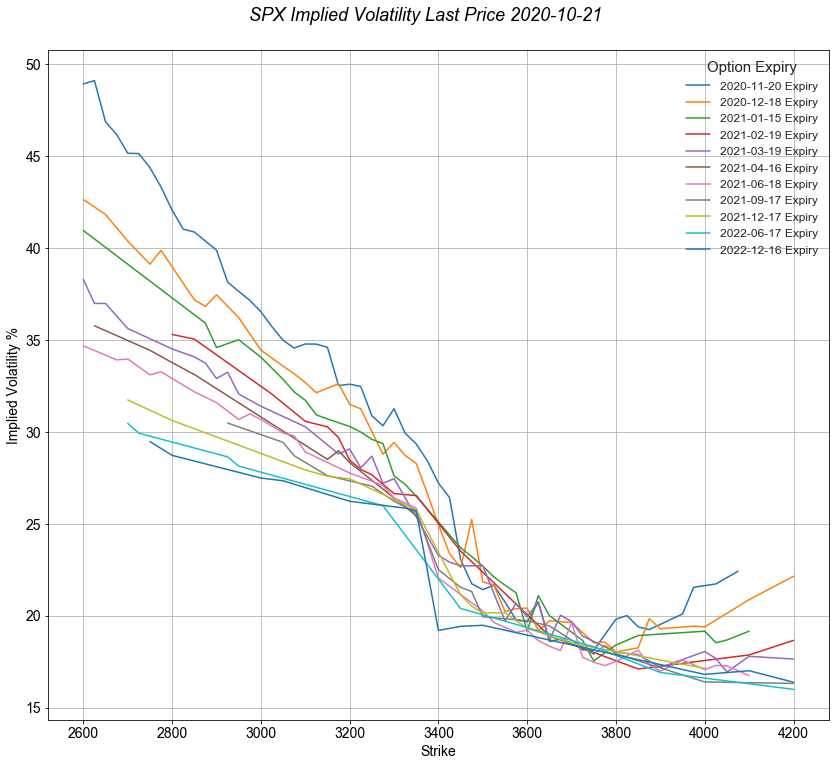

In [19]:
visualize(imp_vol_data, graphtype='line')

### Display a 3D scatter plot of the implied volatilities by strike and tenor, choose bid, mid, ask or last price to calculate implied vol 

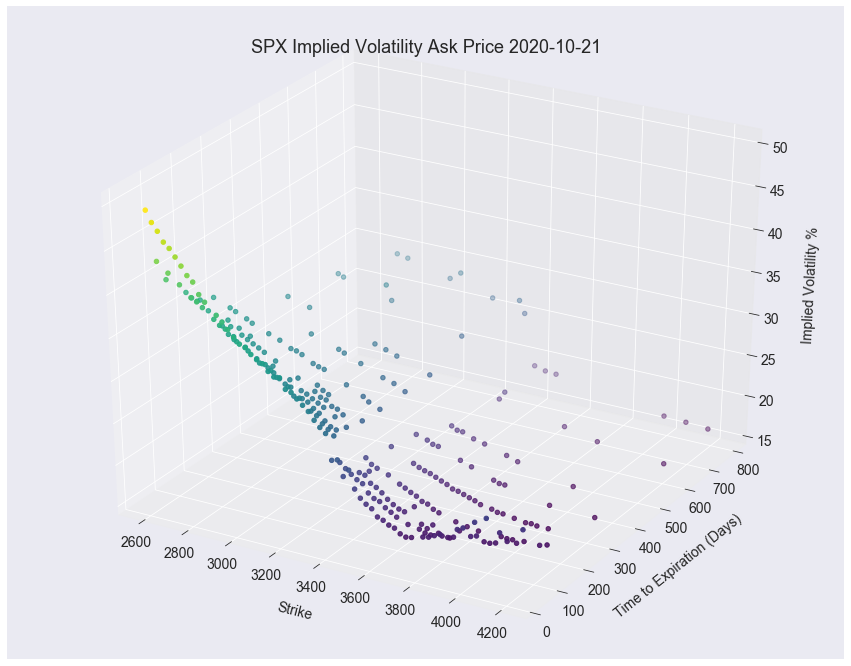

In [20]:
visualize(imp_vol_data, graphtype='scatter', voltype='ask')

### Display a 3D surface plot of the implied volatilities by strike and tenor - Triangular Surface plot

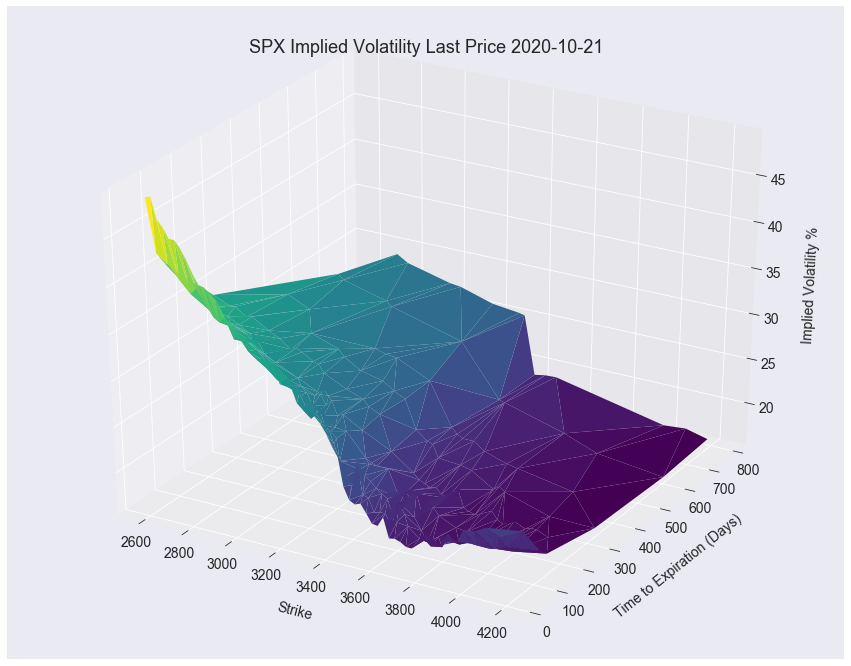

In [21]:
visualize(imp_vol_data, graphtype='surface', surfacetype='trisurf', smoothing=False)

### Display a 3D surface plot of the implied volatilities by strike and tenor - Triangular Surface plot with 3rd order polynomial smoothing

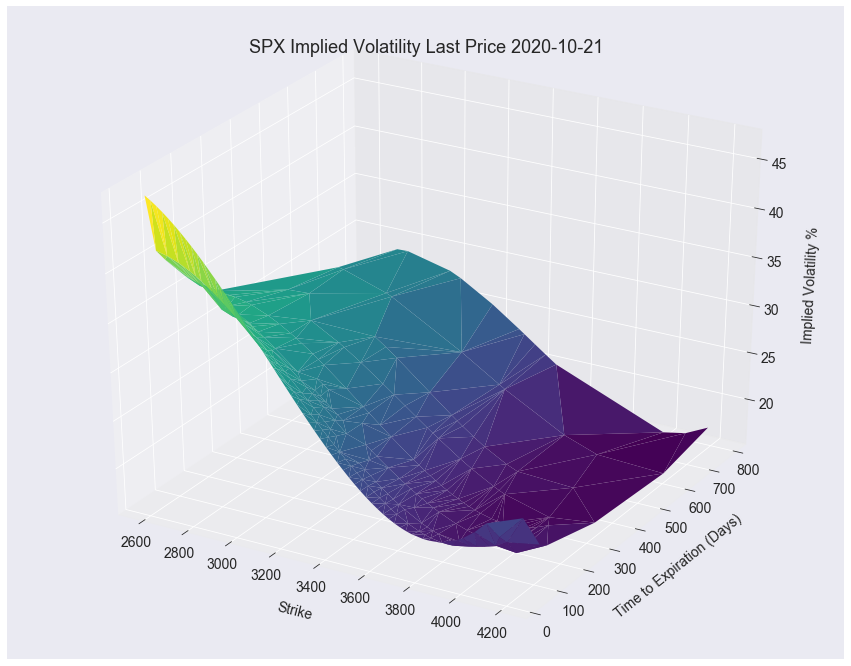

In [22]:
visualize(imp_vol_data, graphtype='surface', surfacetype='trisurf', smoothing=True, voltype='last')

### Display a 3D surface plot of the implied volatilities by strike and tenor - meshgrid plot with smoothing

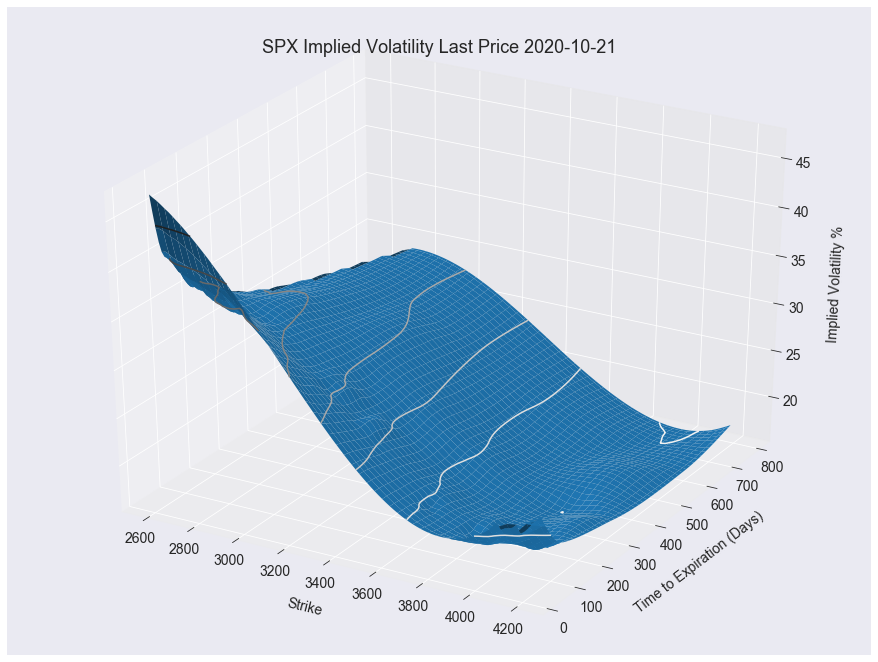

In [23]:
visualize(imp_vol_data, graphtype='surface', surfacetype='mesh', smoothing=True)

### Display a 3D surface plot of the implied volatilities by strike and tenor - meshgrid plot with smoothing, radial basis function with scatter overlay

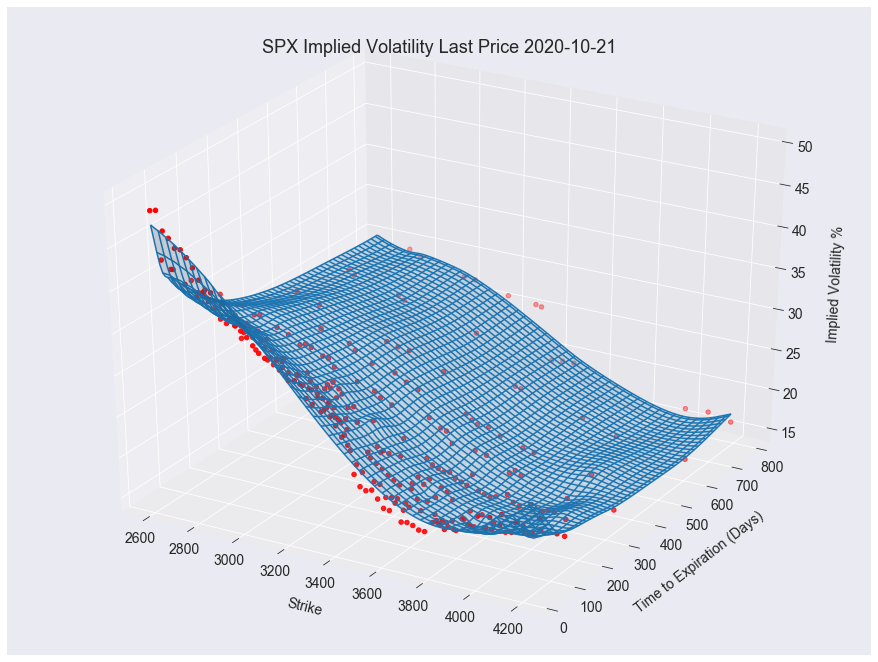

In [24]:
visualize(imp_vol_data, graphtype='surface', surfacetype='spline', scatter=True, smoothing=True)

### Display a 3D surface plot of the implied volatilities by strike and tenor - Plotly interactive meshgrid plot with smoothing

In [25]:
visualize(imp_vol_data, graphtype='surface', surfacetype='interactive_mesh', smoothing=True, notebook=True)

### Display a 3D surface plot of the implied volatilities by strike and tenor - Plotly interactive spline plot with smoothing

In [26]:
visualize(imp_vol_data, graphtype='surface', surfacetype='interactive_spline', smoothing=True, notebook=True)

### Display a 3D surface plot of the implied volatilities by strike and tenor - Plotly interactive spline plot with smoothing, cubic radial basis function, colorscale jet

In [27]:
visualize(imp_vol_data, graphtype='surface', surfacetype='interactive_spline', rbffunc='cubic', 
              colorscale='Jet', smoothing=True)